In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as colors

from astropy.visualization import astropy_mpl_style
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

import scipy.stats as stat
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_prominences, peak_widths
from scipy.stats import linregress

import itertools

import helperfile as hf


In [2]:
# STEP 1: Load Data 
xy = np.loadtxt('XY_ZeroB_Dic.txt', dtype=int, delimiter=',')
print(type(xy))
print(f"Number of trials to examine = {len(xy)/2}\nTotal Number of arrays = {len(xy)}")

<class 'numpy.ndarray'>
Number of trials to examine = 2.0
Total Number of arrays = 4


In [3]:
# # STEP 2: Check all graphs  

# hf.MakeManyPlots(xy)

Data ratio set


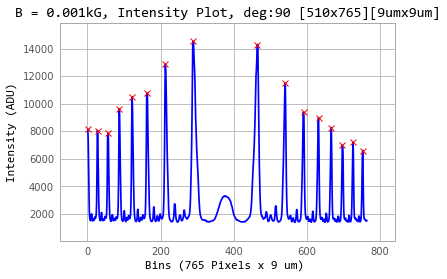

In [4]:
peaks1, x_1, y_1 = hf.LabelPeaks_ShrinkData(xy[0],xy[1],1,764,4000)

hf.Plots(x_1,y_1, 
    'B = 0.001kG, Intensity Plot, deg:90 [510x765][9umx9um]', 
    'Bins (765 Pixels x 9 um) ', 'Intensity (ADU)', 
    # figsize0=12, figsize1=8
    )
hf.PlotNewPeaks(peaks1,xy[1])


hf.SaveFigure('Graphs/B0Intenisty.png')

Data ratio set


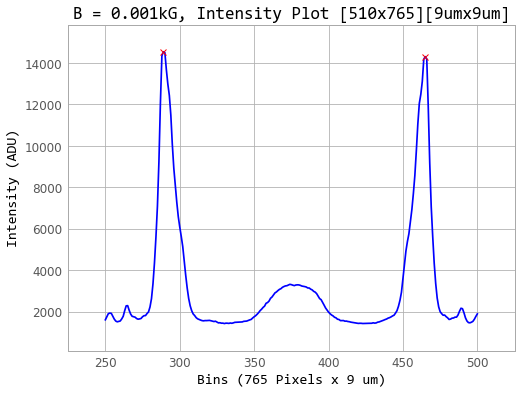

In [5]:
peak, x, y = hf.LabelPeaks_ShrinkData(xy[0],xy[1],250,500,6000)
hf.Plots(x,y, 
    'B = 0.001kG, Intensity Plot [510x765][9umx9um]', 
    'Bins (765 Pixels x 9 um)', 'Intensity (ADU)', 
    # figsize0=12, figsize1=6
    )
hf.PlotNewPeaks(peak,xy[1])
hf.SaveFigure("Graphs/B0ExampleIntensity.png")


In [6]:
# STEP 6: CREATE RADIUS ARRAY 

Radii1_meter_inner2outer = hf.RadiiMeterInner_to_Outer(peaks1)



In [7]:
# STEP 7: CREATE THETA ARRAYS 
thetas1 = hf.ThetasRadArray(Radii1_meter_inner2outer)
T1 = thetas1**2

In [8]:
# Test block
# d = (723-17)*9*10E-6
# r = d/2
# t = r/135E-3
# t2 = t**2
# print(t2)

# for x,y in zip(thetas2, T2):
#     print(f"{x},\t{y}")

In [9]:
# STEP 8: CREATE RING INDEX VALUES

index1 = np.arange(1,len(thetas1)+1)
print(index1)
print(type(index1))


[1 2 3 4 5 6 7 8]
<class 'numpy.ndarray'>


In [10]:
# STEP 9: Error propagation

# ERROR IN MEASUREMENT OF PEAK 
sigma_xf_pixel = 1.3/2 #width/2
sigma_xf_meter = (1.3/2)*9*(10)**(-6) #Pixel x 9um x 10E-6= meter

sigma_xi_pixel = 1.3/2
sigma_xi_meter = (1.3/2)*9*(10)**(-6) #Pixel x 9um x 10E-6= meter

# ERROR PROPAGATION TO DIAMETER
var_D = sigma_xf_meter**2 + sigma_xi_meter**2
sigma_D_meter = np.sqrt(var_D)

# ERROR PROPAGATION TO RADIUS
sigma_R_meter = 0.5*sigma_D_meter

# ERROR PROPAGATION TO ANGLE THETA
f = 135E-3 # focal length 
var_theta = ((1/f)**2)*sigma_R_meter**2
sigma_theta = np.sqrt(var_theta)

Sig_theta_arr1 = sigma_theta*np.ones(len(thetas1))
# Sig_theta_arr2 = sigma_theta*np.ones(len(thetas2))

# print(Sig_theta_arr1)
# print(Sig_theta_arr2)

$$
\sigma_{\theta^2} = (2\theta)(\sigma_{theta})
$$

In [11]:
# CONT. 
# from above formula 
sigTsq1 = 2*thetas1*Sig_theta_arr1

In [12]:
# STEP 10: CREATE FIT FUNCTION 

# TH^2 = (Lambda/t)*index + e(lambda)

# Linear eqation 
def Thetasq1(index,A, b):
    '''Fit the transition wavelength: 
        TH^2 = (Lambda/t)*index + e(lambda)'''
    lambda_0 = 546.07E-9 #meters
    t = 0.6499E-2 # meters
    t_inv = 1/t
    # b is the intercept but this value is unknown 
    # b = e(lambda)
    return A* t_inv * index + b

# Initial Parameters are not given because the intercept is not known
# p01 = [8.6E-05]


In [13]:
# STEP 11: APPLY FIT--------------

# TWO UNKNOWNS 
print('Known: lambda = 5.4607E-07\n\nFit value:\n Lambda & e(lambda)')
popt1, pcov1 = curve_fit( 
                    Thetasq1,
                    index1,
                    T1,
                    # p0= p01, 
                    absolute_sigma=True,
                    sigma=sigTsq1
                    )

for i in range(0,len(popt1)):
    print('param ',i,' = ',popt1[i], '+/-', np.sqrt(pcov1[i,i]))

Known: lambda = 5.4607E-07

Fit value:
 Lambda & e(lambda)
param  0  =  5.500054541347221e-07 +/- 8.812851169562223e-10
param  1  =  -5.012096340144326e-05 +/- 4.123751380934265e-07


True Value: 
5.4607e-07

Curve Fit Value: 
[ 5.50005454e-07 -5.01209634e-05]


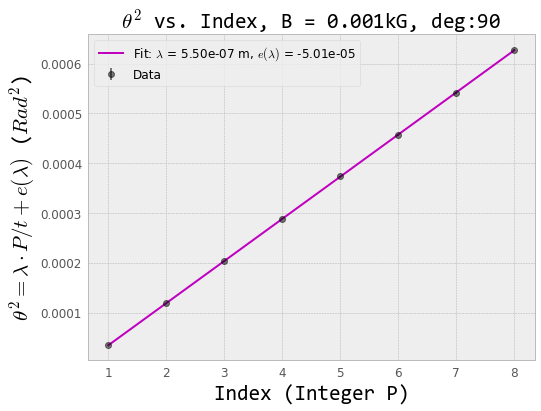

In [14]:
# PLOT

#style
hfont = {'fontname':'Consolas',
         'size': 21}
plt.figure()
plt.style.use('bmh')


# Better looking line
i_line = np.linspace(min(index1), max(index1), 1000)
fit = Thetasq1(i_line, *popt1)

#data
plt.plot(i_line,
         fit,
         label = 'Fit: $\\lambda$ = %1.2e m, $e(\\lambda)$ = %1.2e' % tuple(popt1), 
         color = 'm')

plt.errorbar(
    index1, 
    T1, 
    yerr= sigTsq1, 
    fmt='o', 
    label = 'Data', 
    color='black',
    alpha =0.5
    )

#labels
plt.title(f"$\\theta^2$ vs. Index, B = 0.001kG, deg:90", **hfont)
plt.xlabel('Index (Integer P)', **hfont)
plt.ylabel(f'$\\theta^2 = \\lambda \\cdot P/ t + e(\\lambda)$ ($Rad^2$)', **hfont)
plt.legend(loc=2)

lambda_0 = 546.07E-9 #meters
t = 0.6499E-2
print('True Value: ') 
print(lambda_0)
# print('\nPolyfit Value:')
# print(np.polyfit(index2,T2,1)[0])
print('\nCurve Fit Value: ')
print(popt1)

hf.SaveFigure('Graphs/B0Fit.png')


# Statistical Analysis 

In [15]:
print('Fit:lambda fix: 1/t')
hf.Chi2Values(Thetasq1,index1,T1,popt1,sigTsq1) # not significant

# print('\nFit - Graph 2: A = lambda/t')
# hf.Chi2Values(Thetasq1,index2,T2,popt1_2,sigTsq2)

# z- score? 
z = 0.54 # about half a standard devation away
z = 0.55 # I stil don't think Chi2 get zscores.. 

Fit:lambda fix: 1/t
Chi-square:  3.2153674023630696
Degrees of freedom:  6
Reduced chi-square:  0.5358945670605116
CDF:  0.21862908334170963
p-test value (1 Tail bc not symmetric):  0.7813709166582904


In [16]:
# Error Values
print(f"True: {lambda_0}")
print(f"Fit: {popt1[0]:.4e}")

print('\n Percent error using the fit value:')
percentage_error = (np.abs(lambda_0-popt1[0])/lambda_0)*100
print(percentage_error)


True: 5.4607e-07
Fit: 5.5001e-07

 Percent error using the fit value:
0.7206867498163458
